In [9]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


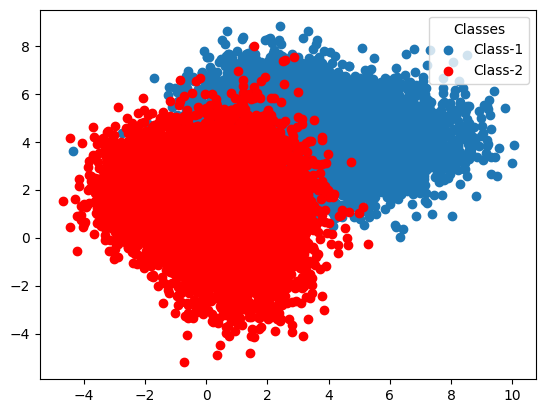

In [10]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.metrics import roc_curve
import torch.utils.data as data_utils



# hyperparameteres: activation function, unit size, iteration size
act_func_list = ["sigmoid", "tanh", "relu"]
act_func = "sigmoid"

n_hidden_l = 5

opt_list = ["adam", "sgd"]
opt = "adam"


epoch = 5
learn_r = 0.01 # we need to tune this


# load train data
c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/train_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

x = np.concatenate( (c0, c1), axis=1 )
x_trn = torch.from_numpy(x.T)

y = np.concatenate( (np.zeros(shape=(1, c0.shape[1])),
                     np.ones(shape=(1, c1.shape[1]))), axis=1 )
y_trn = torch.from_numpy(y.T)

d = c0.shape[0] # input feature size

# Defining input size, and output size respectively
n_in, n_out = d, 1

# plot the train data
plt.scatter(c0[0,:], c0[1,:])
plt.scatter(c1[0,:], c1[1,:], c='r')

plt.legend(("Class-1", "Class-2"), loc="upper right", title="Classes")
plt.show()


# load the test data
c0 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c0']
c1 = loadmat('/content/drive/MyDrive/Colab Notebooks/EE423/test_binary_oct22.mat')['c1']
c0 = c0 + 3*np.ones((3,1))

x = np.concatenate( (c0, c1), axis=1 )
x_test = torch.from_numpy(x.T)
y = np.concatenate( (np.zeros(shape=(1, c0.shape[1])),
                     np.ones(shape=(1, c1.shape[1]))), axis=1 )
y_test = torch.from_numpy(y.T)




In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Create a model
model = nn.Sequential(nn.Linear(n_in, n_hidden_l, bias = True),
   nn.ReLU(),
   nn.Dropout(0.5),
   nn.Linear(n_hidden_l, n_out),
   nn.Sigmoid())

# data is in double format but the model assumes float input
# you can either convert model to accept double or convert
# data to float format.
model = model.double()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=5, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=5, out_features=1, bias=True)
  (4): Sigmoid()
)

In [13]:


train = data_utils.TensorDataset(x_trn, y_trn)
train_loader = data_utils.DataLoader(train, batch_size = 100, shuffle = True)

x_test = x_test.to(device)
y_test = y_test.to(device)

# Construct the loss function
# binary cross entropy
criterion = nn.BCELoss()

In [14]:

import time
from torch.utils.tensorboard import SummaryWriter

# Create a writer instance
writer = SummaryWriter('logs/experiment_2')


# Construct the optimizer (Stochastic Gradient Descent in this case)
if opt == "sgd":
   # L2 regularization is performed if weight_decay parameter is specified
   optimizer = torch.optim.SGD(model.parameters(), lr = learn_r, weight_decay=0.1)
else:
   optimizer = torch.optim.Adam(model.parameters(),lr = learn_r, betas = (0.9, 0.999))


# check this out
#train_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=1, pin_memory=True)


start = time.time()

# Gradient Descent
iter=0
for epoch in range(epoch):

    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Forward pass: Compute predicted y by passing x to the model
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        # Compute and print loss
        loss = criterion(y_pred, y_batch)

        # add loss to logs
        writer.add_scalar('Training loss', loss, iter)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()

        iter = iter+1

        if iter % 100 == 0:

            # convert back to the numpy format from the pytorch format
            y_pred = model(x_test)

            # Get predictions from the maximum value
            predicted = torch.round(y_pred)

            correct = (predicted == y_test).sum()
            acc = correct/y_test.shape[0]
            writer.add_scalar('Accuracy', acc, iter)

            print("Accuracy:", str(acc))
end = time.time()

print(f"total time is {end-start}")

writer.close()


Accuracy: tensor(0.8350)
Accuracy: tensor(0.8561)
Accuracy: tensor(0.8561)
Accuracy: tensor(0.8630)
Accuracy: tensor(0.8628)
Accuracy: tensor(0.8635)
Accuracy: tensor(0.9251)
Accuracy: tensor(0.9230)
Accuracy: tensor(0.9217)
Accuracy: tensor(0.9263)
total time is 4.823141813278198


In [15]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1140), started 0:04:25 ago. (Use '!kill 1140' to kill it.)

<IPython.core.display.Javascript object>